# Feature Analysis
## Haralick EBImage features

This analysis deals with haralick features extracted from the human organoids. For these features, the organoids were not observed individually, i.e. only the foreground vs. background was segmented. Features are shape-independent texture features (Haralick features of the EBImage package)

In [ ]:
# Install and load libraries
library(PROMISE)
library(ggplot)
if (!require("dendextend")) install.packages("dendextend"); library(dendextend)

In [1]:
configdir = "/collab-ag-fischer/PROMISE/data-10x-4t-c-16z/configdir"

# The two replicates
platename_rep1 = "D004T01P005L08"
platename_rep2 = "D004T01P009L08"

# Load layout and features
layout = loadLibrary(platename_rep1, configdir)
features_rep1 = loadFeatures(platename_rep1, configdir)
features_rep2 = loadFeatures(platename_rep2, configdir)

# Average the fields for each replicate
wells = features_rep1$wells
features_rep1 = features_rep1[,colnames(features_rep1)[!colnames(features_rep1) %in% c("wells")]]
features_rep1 = aggregate(features_rep1, list(wells), mean)
wells = features_rep2$wells
features_rep2 = features_rep2[,colnames(features_rep2)[!colnames(features_rep2) %in% c("wells")]]
features_rep2 = aggregate(features_rep2, list(wells), mean)

# A sanity check to ensure that the replicates are in the same order
if(!identical(features_rep1$Group.1, features_rep2$Group.1)) {
  stop(sprintf("Replicates for '%s / %s' not in the same order", platename_rep1, platename_rep2))
}

# Add layout information
wells = features_rep1$Group.1
drugs = as.character(layout[wells, "Product.Name"])
concentration = layout[wells, "concentration"]
drug_id = drugs
drug_id[!drugs %in% c("DMSO", "Staurosporine_500nM")] = paste0(
  drugs[!drugs %in% c("DMSO", "Staurosporine_500nM")], "_", 
  concentration[!drugs %in% c("DMSO", "Staurosporine_500nM")])

# Remove the now duplicate group column (this is generated by 'aggregate()')
features_rep1 = features_rep1[,colnames(features_rep1) != "Group.1"]
features_rep2 = features_rep2[,colnames(features_rep2) != "Group.1"]
rownames(features_rep1) = rownames(features_rep2) = wells

### Feature Selection

Features are selected based on their correlation between replicates

In [2]:
correlations = setNames(
  object = vector(mode = "numeric", length = ncol(features_rep1)),
  nm = colnames(features_rep1))
for(feature_name in colnames(features_rep1)) {
  vals_rep1 = features_rep1[[feature_name]]
  vals_rep2 = features_rep2[[feature_name]]
  correlations[feature_name] = cor(vals_rep1, vals_rep2)
}
correlations = sort(correlations, decreasing = TRUE)

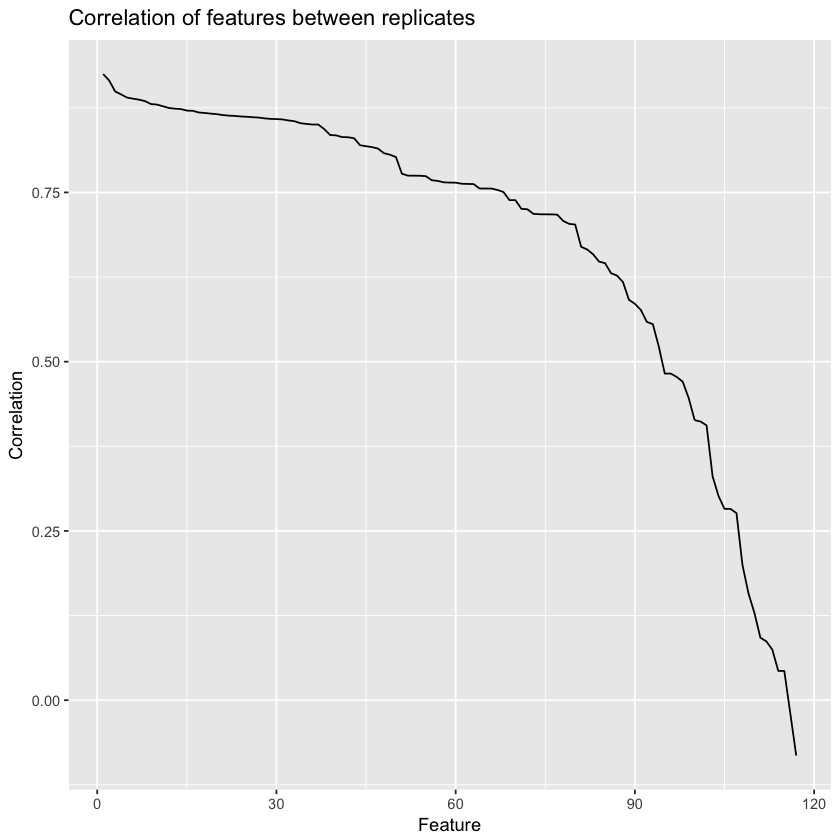

In [3]:
df = data.frame(
    "correlation" = correlations, 
    name = seq_len(length(correlations)))
ggplot(data = df) + geom_line(aes(x = name, y = correlation)) + 
    xlab("Feature") + ylab("Correlation") + 
    ggtitle("Correlation of features between replicates")

I arbitrarily choose a cutoff of 0.8 for the features to keep

In [4]:
correlation_cutoff = 0.8
features_to_keep = names(correlations[correlations > correlation_cutoff])
features_rep1 = features_rep1[,features_to_keep]
features_rep2 = features_rep2[,features_to_keep]

In addition, I want to filter out features that do not differentiate between drugs. To this end, I run an ANOVA test to determine which features show significant variation between groups versus within replicates (biological and on-plate replicates). The ratio of this between-group variance to within-group variance is plotted below. The p-values indicate whether there is a significantly higher contribution to the variance from the drug-concentration combination than from the replicates.

In [5]:
separability = setNames(
  object = vector(mode = "numeric", length = ncol(features_rep1)),
  nm = colnames(features_rep1))
pvalue = setNames(
  object = vector(mode = "numeric", length = ncol(features_rep1)),
  nm = colnames(features_rep1))
for(feature_name in colnames(features_rep1)) {
  vals = c(features_rep1[[feature_name]], features_rep2[[feature_name]])
  group = factor(c(drug_id, drug_id))
  
  # Within group and between group variance definition from here:
  # https://stackoverflow.com/questions/1401894/
  #         calculate-within-and-between-variances-and-confidence-intervals-in-r
  fit = anova(lm(vals ~ group))
  wg_var = fit["Residuals", "Mean Sq"]
  bg_var = fit["group", "Mean Sq"]
  separability[feature_name] = bg_var / wg_var
  pvalue[feature_name] = fit["group", "Pr(>F)"]
}
separability = sort(separability, decreasing = TRUE)

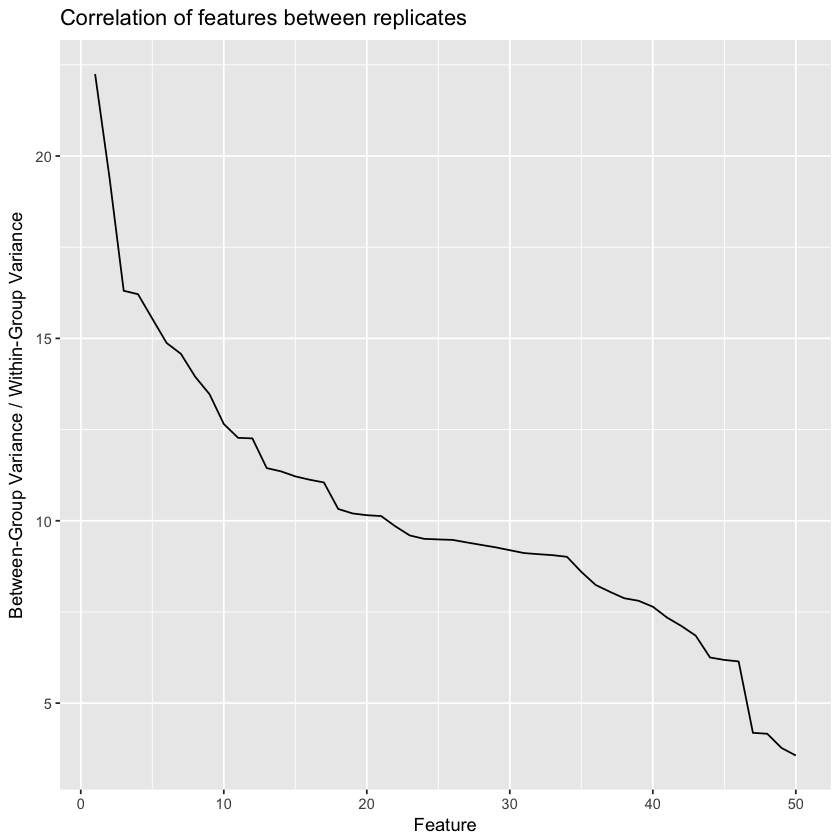

In [6]:
df = data.frame(
  "separability" = separability, 
  name = seq_len(length(separability)))
ggplot(data = df) + geom_line(aes(x = name, y = separability)) + 
  xlab("Feature") + ylab("Between-Group Variance / Within-Group Variance") + 
  ggtitle("Correlation of features between replicates")

In [7]:
summary(pvalue, digits=7)

        Min.      1st Qu.       Median         Mean      3rd Qu.         Max. 
0.000000e+00 0.000000e+00 0.000000e+00 1.736270e-36 0.000000e+00 8.669307e-35 

All features show significantly more variation based on the drug-concentration treatment than within replicates. This is to be expected as the features were already selected based on their correlation between replicates, but serves as a confirmation of that choice.

In [8]:
features_rep1 = features_rep1[,names(pvalue[pvalue < 0.05])]
features_rep2 = features_rep2[,names(pvalue[pvalue < 0.05])]

### Hierarchical clustering of drugs

For the hierarchical cluster, use the average of the features across both replicates. Likewise, average together all wells treated with the same drug-concentration combination. As proof of concept, the DMSO (negative control) is highlighted red and the Staurosporine (positive control) is highlighted green. They are on completely opposite branches of the dendrogram, indicating that the features sufficiently encode the vitality status (living versus dead) of the organoids.

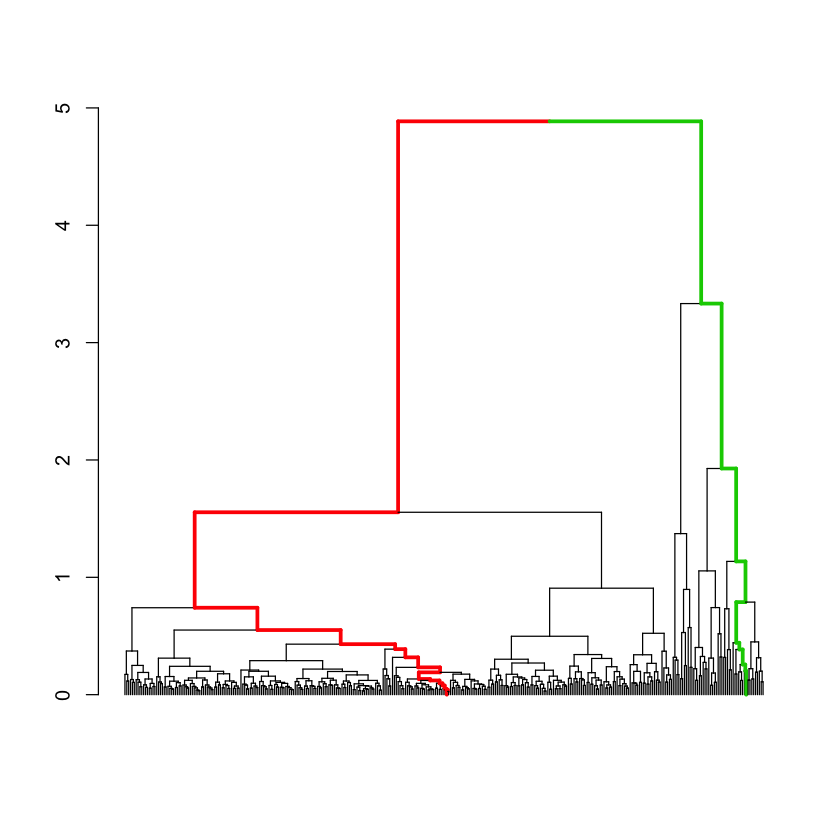

In [55]:
features_mean = (features_rep1 + features_rep2) / 2
features_mean = aggregate(features_mean, list(drug_id), mean)
rownames(features_mean) = features_mean$Group.1
features_mean = features_mean[,colnames(features_mean) != "Group.1"]

drug_distances = dist(features_mean)
dend = as.dendrogram(hclust(drug_distances))

# Highlight the DMSO and Staurosporine branches
dend = set(
    dend = dend, what = "by_labels_branches_col", 
    value = "DMSO", type = "any", TF_value = 2)
dend = set(
    dend = dend, what = "by_labels_branches_col", 
    value = "Staurosporine_500nM", type = "any", TF_value = 3)
dend = set(
    dend = dend, what = "by_labels_branches_lwd", 
    value = "DMSO", type = "any", TF_value = 3)
dend = set(
    dend = dend, what = "by_labels_branches_lwd", 
    value = "Staurosporine_500nM", type = "any", TF_value = 3)
plot(dend, leaflab = "none")

It is interesting to note that there are some drug pairs, which have a larger distance that that between the DMSO and Staurosporine features.

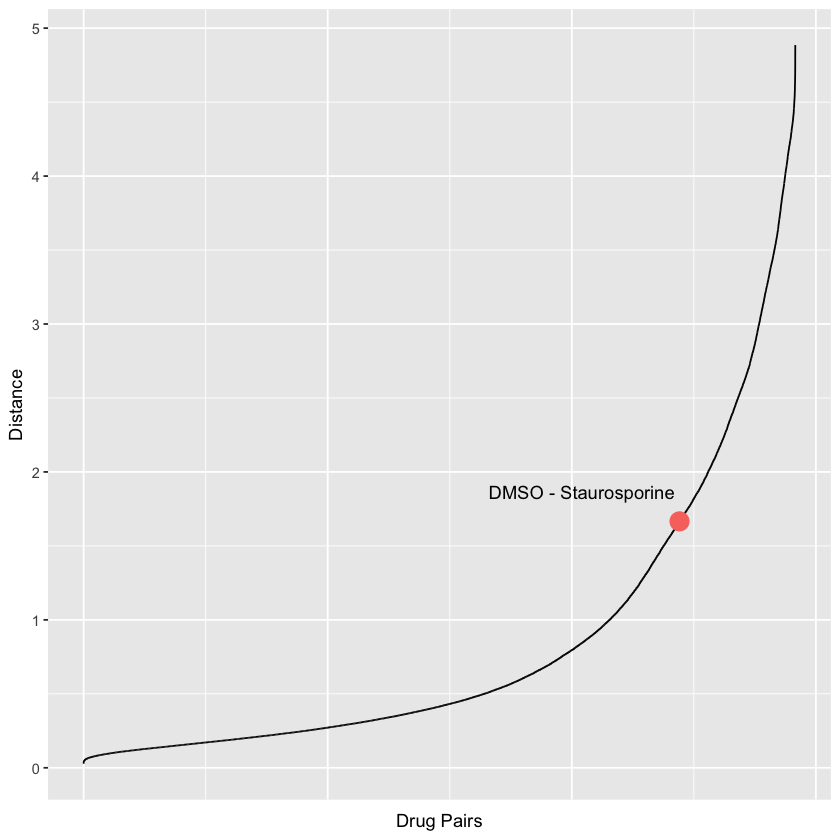

In [77]:
all_distances = data.frame("x" = seq_along(unique(drug_distances)), "Distance" = sort(unique(drug_distances)))
pos_neg_dist = as.matrix(drug_distances)["DMSO", "Staurosporine_500nM"]
pos_neg_x = all_distances[all_distances$Distance == pos_neg_dist, "x"]
ggplot(data = all_distances) + geom_line(aes(x = x, y = Distance)) + 
    xlab("Drug Pairs") + 
    theme(axis.text.x = element_blank(), 
          axis.ticks.x = element_blank(), 
          legend.position = "none") + 
    geom_point(
        data = data.frame(X = pos_neg_x, Y = pos_neg_dist), 
        aes(x=X, y=Y, color = "red"), size=5) + 
    annotate("text", label = "DMSO - Staurosporine", x = pos_neg_x - 8000, y = pos_neg_dist + 0.2)

In order to further validate the relevance of the features, the drugs should be clustered by mode of action.

**At this point, having the modes of action of all the drugs *a priori* would make it much easier to determine how well the clustering coincides with the modes of action. Otherwise, an arbitrary number of clusters must be defined and the drugs therein manually checked**

Alternatively, look at the drugs *sans* concentrations and see if they all end up in the same clusters or if, e.g. certain drugs with high concentrations cluster together